In [1]:
import torch
from torchvision import models
import numpy as np

from matplotlib import pyplot as plt
import cv2

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
from pytorch_grad_cam.utils.model_targets import RawScoresOutputTarget

from utils import load_img, ResnetFeatureExtractor, make_comparison_plot

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
resnet = models.resnet50(pretrained=True).to(device)
resnet.eval()
model = ResnetFeatureExtractor(resnet)

/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


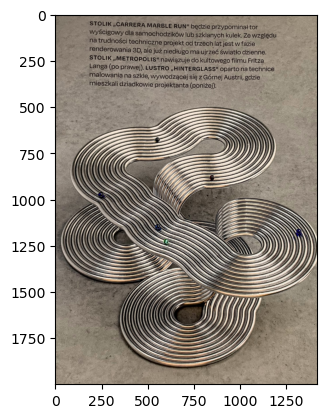

In [4]:
im1 = load_img("../data/web/20B_2.png")

plt.imshow(im1)
plt.show()

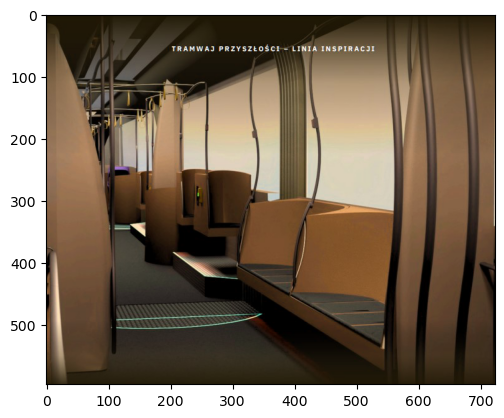

In [5]:
im2 = load_img("../data/final_submissions/20/8.jpg")
plt.imshow(im2)
plt.show()

0.6649418


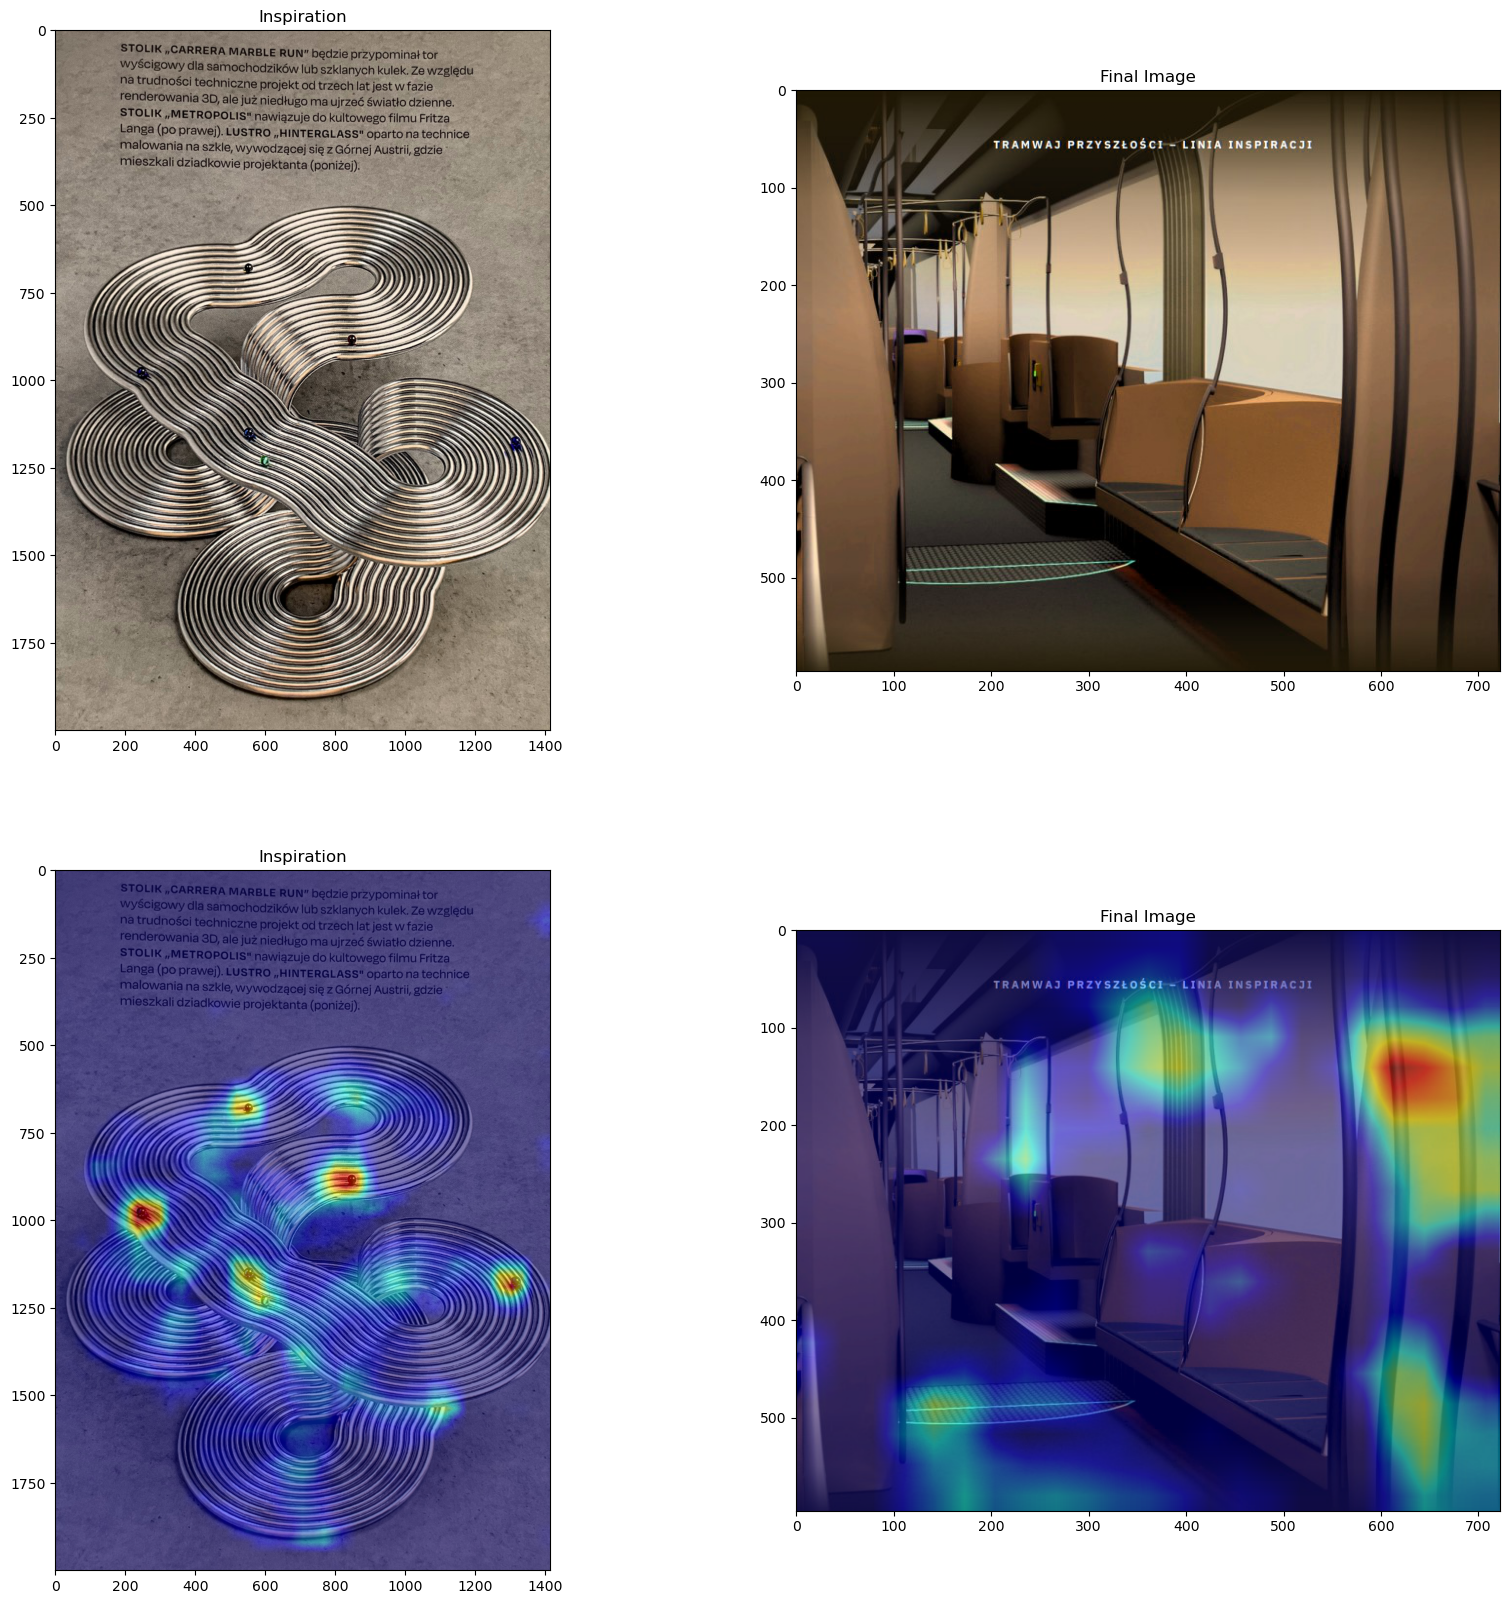

In [6]:
make_comparison_plot(im1,im2,model,device)